# Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий

**Цель:** изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык **Python** и библиотеки **PM4PY**, **Pandas**.

**Данные:**

## Начало работы. Чтение журнала событий

Библиотека **pm4py** работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:
- **converter** из `pm4py.objects.conversion.log` (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий; 
- **importer** из `pm4py.objects.log.importer.xes` (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки `pm4py.objects.conversion.log.converter` преобразуем его в журнал событий.


In [1]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=665a4214c40d8a9ebef1a0d9d78ee4a5a9e3ecf3e886cec389996e28b1b51117
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
  Created wheel for stringdist: filename=StringDist-1.0.9-cp39-cp39-linux_x86_64.whl size=24707 sha256=dc09b5b00e1a2c0affb747a87da1dd275e1233f49a8f9198b8932ca7197479d5
  Stored in directory: /root/.cache/pip/wheels/77/24/44/b12b9612fd07e141e6b4f1bb2001c621515bd0cac1014a783a
Successfully built intervaltree stringdist


In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [ ]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [3]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('https://raw.githubusercontent.com/Adelaaas/Process_mining_lab_hes/main/ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [4]:
type(log_csv)

pandas.core.frame.DataFrame

**Перед началом работы с любым набором данных, необходимо сначала его изучить:**
- названия колонок
- типы данных
- пропущенные значения
- и другое

In [5]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [6]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [7]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [8]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [9]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

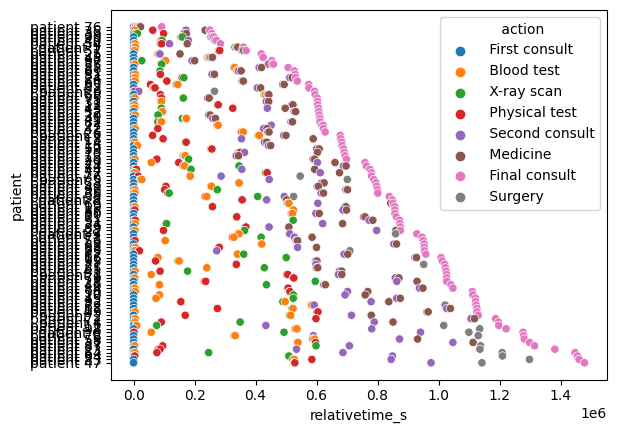

In [10]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [11]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [12]:
len(log_csv['patient'].unique())

100

In [13]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

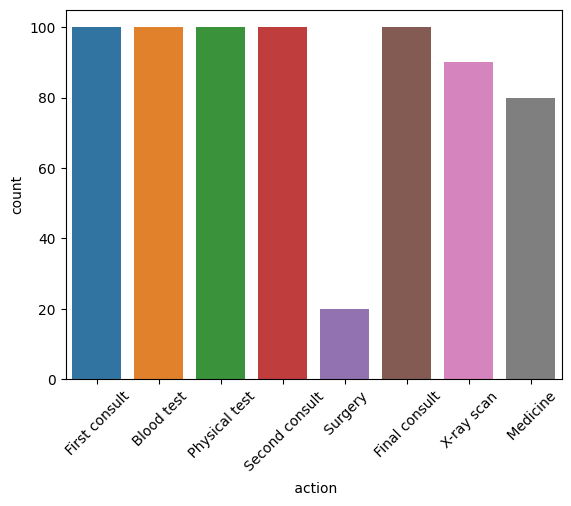

In [14]:
sns.countplot(x=log_csv[' action'])
plt.xticks(rotation=45)

In [15]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

**Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:**

- **Идентификатор случая (case id):** хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- **Деятельность (activity name):** хранит действия, выполняемые в рамках событий журнала.
- **Отметка времени (timestamp):** хранит дату и время регистрации событий журнала.
- **Ресурс (resource):** хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- **Прочее (other data):** сюда попадает вся оставшаяся в журнале (не интересная нам) информация. 

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [16]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [17]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [18]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [19]:
log_csv.shape

(690, 10)

In [20]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [21]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [22]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [23]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [24]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [25]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [26]:
# можно посмотреть на эти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

## Построение модели по журналу событий

### Alpha Miner

**Alpha miner** — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [27]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

Полученный процесс мы можем отобразить с помощью **Сетей Петри**.

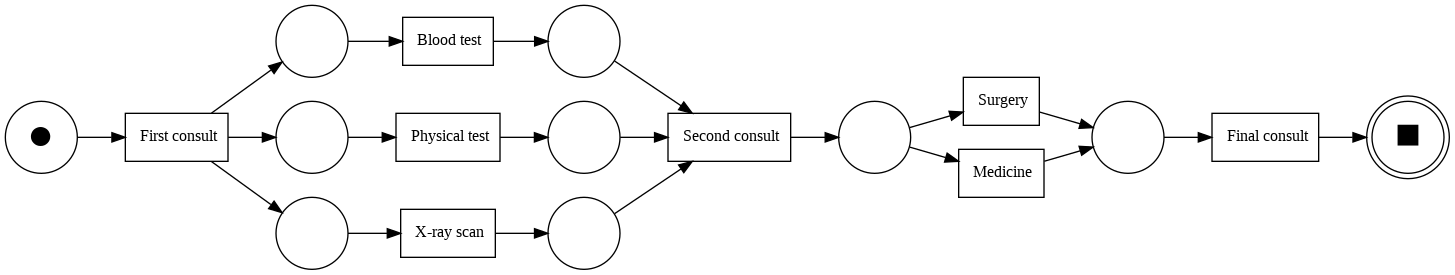

In [28]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import graphviz

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр `pn_visualizer.Variants.FREQUENCY` при вызове `pn_visualizer.apply()`.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

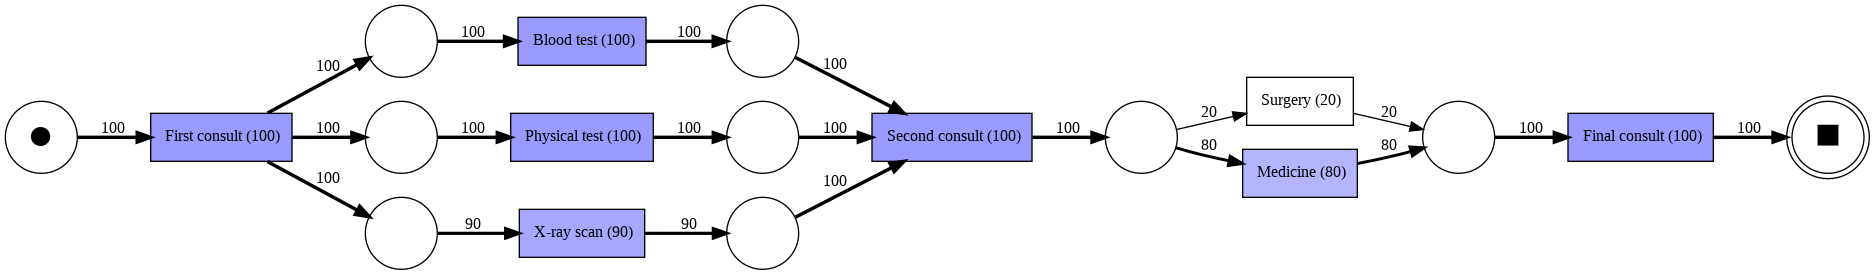

In [29]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [30]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция `get_transition_performance_with_token_replay` принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [31]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( Physical test, ' Physical test')", "( X-ray scan, ' X-ray scan')", "( Blood test, ' Blood test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [33]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

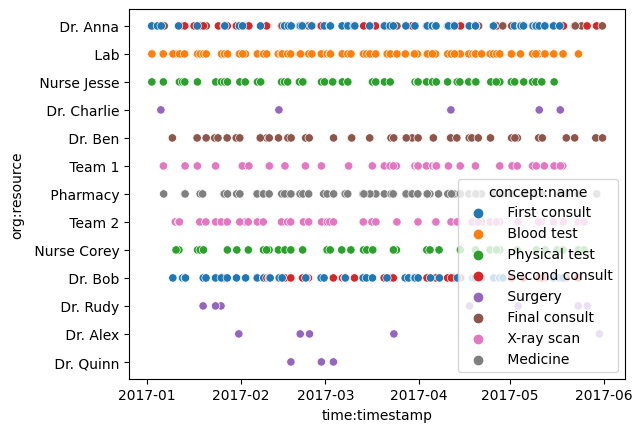

In [34]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

## Задания. Изучение журнала событий

1. Каково минимальное и максимальное количество событий в одном случае?
2. Какие события являются общими для всех процессов?
3. Найдите наибоее часто встречающуюся последовательность событий.
4. Какой пациент на лечение тратил меньше всего времени, а какой больше?
6. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
7. Pation 13 с каким врачом/врачами он/она консультировался?
8. Какое событие является наиболее ресурсоёмким в данном журнале событий?
9. Есть ли врачи или медсестры, которые перегружены работой?
10. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
11. Какие события связаны с узкими местами и какие ресурсы задействованы?
12. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

#### **1. Каково минимальное и максимальное количество событий в одном случае?**

In [35]:
print(f'Минимальное количество событий: {min(patient_events.sum(axis=1))}', f'Максимальное количество событий: {max(patient_events.sum(axis=1))} ',sep = '\n')

Минимальное количество событий: 6
Максимальное количество событий: 7 


#### **2. Какие события являются общими для всех процессов?**

In [37]:
patient_events.sum() == 100
# Если значение равно True, то данное событие является общим для всех процессов

 action
 Blood test         True
 Final consult      True
 First consult      True
 Medicine          False
 Physical test      True
 Second consult     True
 Surgery           False
 X-ray scan        False
dtype: bool

#### **3. Найдите наибоее часто встречающуюся последовательность событий**

In [ ]:
variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

In [39]:
print(max(variants_count, key=lambda x:x['count']))

{'variant': (' First consult', ' Blood test', ' X-ray scan', ' Physical test', ' Second consult', ' Medicine', ' Final consult'), 'count': 18}


#### **4. Какой пациент на лечение тратил меньше всего времени, а какой больше?**

In [41]:
times = log_csv[['case:concept:name', 'caselength']].drop_duplicates()
times = times.groupby('case:concept:name')['caselength'].sum()
print('Пациент, потративший на лечение больше всего времени:', times.idxmax())
print('длительность лечения:', times.loc[times.idxmax()])
print('Пациент, потративший на лечение меньше всего времени:', times.idxmin())
print('длительность лечения:', times.loc[times.idxmin()])

Пациент, потративший на лечение больше всего времени: patient 47
длительность лечения: 17 days 02:43:04
Пациент, потративший на лечение меньше всего времени: patient 76
длительность лечения: 1 days 01:34:04


#### **5. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)**

In [42]:
log_csv['NumActions in Case'] = log_csv.groupby('case:concept:name')['concept:name'].transform('count')
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,6
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,6
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,6
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,6
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,6
...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,7
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,7
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,7
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,7


#### **6. Pation 13 с каким врачом/врачами он/она консультировался?**

In [43]:
log_csv[log_csv['case:concept:name'] == 'patient 13'][['case:concept:name', 'org:resource']]

,case:concept:name,org:resource
89,patient 13,Dr. Bob
90,patient 13,Team 2
91,patient 13,Nurse Jesse
92,patient 13,Lab
93,patient 13,Dr. Anna
94,patient 13,Pharmacy
95,patient 13,Dr. Ben


#### **7. Какое событие является наиболее ресурсоёмким в данном журнале событий?**

In [46]:
log_csv.query(f"relativetime_s == {max(log_csv['relativetime_s'])}")

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
327,patient 47,Final consult,Dr. Anna,2017-03-27 12:10:48,2017-03-27 12:10:48,2017-03-10 09:27:44,17 days 02:43:04,1478584,17,17 days 02:43:04,7


#### **8. Есть ли врачи или медсестры, которые перегружены работой?**

In [45]:
log_csv['org:resource'].value_counts()

 Dr. Anna       158
 Lab            100
 Dr. Bob         92
 Pharmacy        80
 Nurse Jesse     57
 Dr. Ben         50
 Team 2          50
 Nurse Corey     43
 Team 1          40
 Dr. Rudy         7
 Dr. Charlie      5
 Dr. Alex         5
 Dr. Quinn        3
Name: org:resource, dtype: int64

#### **9. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?**

In [49]:
log_csv[['org:resource', 'concept:name']].value_counts()

org:resource  concept:name   
 Lab           Blood test        100
 Pharmacy      Medicine           80
 Nurse Jesse   Physical test      57
 Dr. Anna      Second consult     55
               First consult      53
               Final consult      50
 Dr. Ben       Final consult      50
 Team 2        X-ray scan         50
 Dr. Bob       First consult      47
               Second consult     45
 Nurse Corey   Physical test      43
 Team 1        X-ray scan         40
 Dr. Rudy      Surgery             7
 Dr. Alex      Surgery             5
 Dr. Charlie   Surgery             5
 Dr. Quinn     Surgery             3
dtype: int64

In [47]:
log_csv['org:resource'].value_counts() / log_csv['org:resource'].value_counts().sum()

 Dr. Anna       0.228986
 Lab            0.144928
 Dr. Bob        0.133333
 Pharmacy       0.115942
 Nurse Jesse    0.082609
 Dr. Ben        0.072464
 Team 2         0.072464
 Nurse Corey    0.062319
 Team 1         0.057971
 Dr. Rudy       0.010145
 Dr. Charlie    0.007246
 Dr. Alex       0.007246
 Dr. Quinn      0.004348
Name: org:resource, dtype: float64

#### **10. Какие события связаны с узкими местами и какие ресурсы задействованы?**

In [50]:
import pandas as pd
import numpy as np

seconds_to_hours = 60*60
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)
log_csv['time'] = log_csv['time'] / seconds_to_hours
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               # values=["relativetime_s"],
               values=["time"],
               aggfunc=np.sum)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

#### **11. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?**

In [51]:
df_11 = log_csv.groupby('case:concept:name').head(2).reset_index(drop=True)
df_11

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,6,0 days 00:00:01.122777777
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,6,0 days 00:00:00.104722222
2,patient 1,First consult,Dr. Anna,2017-01-02 12:50:35,2017-01-06 16:49:21,2017-01-02 12:50:35,0 days 00:00:00,0,0,4 days 03:58:46,7,0 days 00:00:01.144166666
3,patient 1,Physical test,Nurse Jesse,2017-01-02 13:59:14,2017-01-06 16:49:21,2017-01-02 12:50:35,0 days 01:08:39,4119,0,4 days 03:58:46,7,0 days 00:00:00.351388888
4,patient 2,First consult,Dr. Anna,2017-01-04 10:02:49,2017-01-17 11:54:48,2017-01-04 10:02:49,0 days 00:00:00,0,0,13 days 01:51:59,7,0 days 00:00:47.036666666
...,...,...,...,...,...,...,...,...,...,...,...,...
195,patient 97,X-ray scan,Team 1,2017-05-17 16:12:44,2017-05-22 14:37:56,2017-05-17 08:44:01,0 days 07:28:43,26923,0,5 days 05:53:55,7,0 days 00:00:20.684722222
196,patient 98,First consult,Dr. Anna,2017-05-17 10:56:48,2017-05-31 14:16:13,2017-05-17 10:56:48,0 days 00:00:00,0,0,14 days 03:19:25,7,0 days 00:02:27.039444444
197,patient 98,X-ray scan,Team 2,2017-05-23 13:59:10,2017-05-31 14:16:13,2017-05-17 10:56:48,6 days 03:02:22,529342,6,14 days 03:19:25,7,0 days 00:00:00.642222222
198,patient 99,First consult,Dr. Bob,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,0 days 00:00:00,0,0,13 days 00:49:32,7,0 days 00:00:01.275833333


In [52]:
df_11_2 = df_11.loc[df_11.index % 2 == 1]
df_11_2

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,6,0 days 00:00:00.104722222
3,patient 1,Physical test,Nurse Jesse,2017-01-02 13:59:14,2017-01-06 16:49:21,2017-01-02 12:50:35,0 days 01:08:39,4119,0,4 days 03:58:46,7,0 days 00:00:00.351388888
5,patient 2,Physical test,Nurse Jesse,2017-01-06 09:05:01,2017-01-17 11:54:48,2017-01-04 10:02:49,1 days 23:02:12,169332,1,13 days 01:51:59,7,0 days 00:01:35.012777777
7,patient 3,Blood test,Lab,2017-01-06 08:15:00,2017-01-17 13:17:06,2017-01-05 16:10:58,0 days 16:04:02,57842,0,11 days 21:06:08,7,0 days 00:02:03.360833333
9,patient 4,Blood test,Lab,2017-01-09 13:44:25,2017-01-23 08:58:31,2017-01-09 12:35:37,0 days 01:08:48,4128,0,13 days 20:22:54,7,0 days 00:00:24.087500
...,...,...,...,...,...,...,...,...,...,...,...,...
191,patient 95,Blood test,Lab,2017-05-15 10:22:25,2017-05-26 10:19:34,2017-05-15 09:15:08,0 days 01:07:17,4037,0,11 days 01:04:26,6,0 days 00:00:04.231388888
193,patient 96,Blood test,Lab,2017-05-15 11:40:18,2017-05-24 16:38:21,2017-05-15 10:31:45,0 days 01:08:33,4113,0,9 days 06:06:36,7,0 days 00:00:27.145277777
195,patient 97,X-ray scan,Team 1,2017-05-17 16:12:44,2017-05-22 14:37:56,2017-05-17 08:44:01,0 days 07:28:43,26923,0,5 days 05:53:55,7,0 days 00:00:20.684722222
197,patient 98,X-ray scan,Team 2,2017-05-23 13:59:10,2017-05-31 14:16:13,2017-05-17 10:56:48,6 days 03:02:22,529342,6,14 days 03:19:25,7,0 days 00:00:00.642222222


In [53]:
df_11_2.sort_values(by=['relativetime'])

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time
13,patient 6,Physical test,Nurse Jesse,2017-01-12 17:40:43,2017-01-27 12:02:52,2017-01-12 17:18:39,0 days 00:22:04,1324,0,14 days 18:44:13,7,0 days 00:00:15.721944444
155,patient 77,Blood test,Lab,2017-04-19 15:08:42,2017-04-28 14:55:23,2017-04-19 14:08:33,0 days 01:00:09,3609,0,9 days 00:46:50,7,0 days 00:01:59.334722222
159,patient 79,Blood test,Lab,2017-04-21 14:42:00,2017-05-03 10:49:42,2017-04-21 13:41:51,0 days 01:00:09,3609,0,11 days 21:07:51,7,0 days 00:02:24.395833333
175,patient 87,Blood test,Lab,2017-05-04 11:57:08,2017-05-19 16:11:27,2017-05-04 10:56:40,0 days 01:00:28,3628,0,15 days 05:14:47,7,0 days 00:00:25.450277777
189,patient 94,Blood test,Lab,2017-05-12 13:51:31,2017-05-29 09:11:38,2017-05-12 12:50:53,0 days 01:00:38,3638,0,16 days 20:20:45,7,0 days 00:00:00.025000
...,...,...,...,...,...,...,...,...,...,...,...,...
95,patient 47,X-ray scan,Team 1,2017-03-16 11:37:27,2017-03-27 12:10:48,2017-03-10 09:27:44,6 days 02:09:43,526183,6,17 days 02:43:04,7,0 days 00:00:00.321111111
197,patient 98,X-ray scan,Team 2,2017-05-23 13:59:10,2017-05-31 14:16:13,2017-05-17 10:56:48,6 days 03:02:22,529342,6,14 days 03:19:25,7,0 days 00:00:00.642222222
75,patient 37,X-ray scan,Team 2,2017-02-28 17:01:18,2017-03-09 12:22:03,2017-02-22 11:41:54,6 days 05:19:24,537564,6,15 days 00:40:09,7,0 days 00:00:00.388055555
125,patient 62,X-ray scan,Team 2,2017-04-06 08:46:50,2017-04-12 15:21:36,2017-03-30 15:19:58,6 days 17:26:52,581212,6,13 days 00:01:38,7,0 days 00:00:00.603333333


Минимальное время: 0 days 00:22:04 (1324 c)  
Максимальное время: 6 days 19:05:18 (587118 c)

In [54]:
print(f'Среднее время: {df_11_2.relativetime_s.mean()} с ({round(df_11_2.relativetime_s.mean() / 3600, 2)} ч)')

Среднее время: 133638.24 с (37.12 ч)


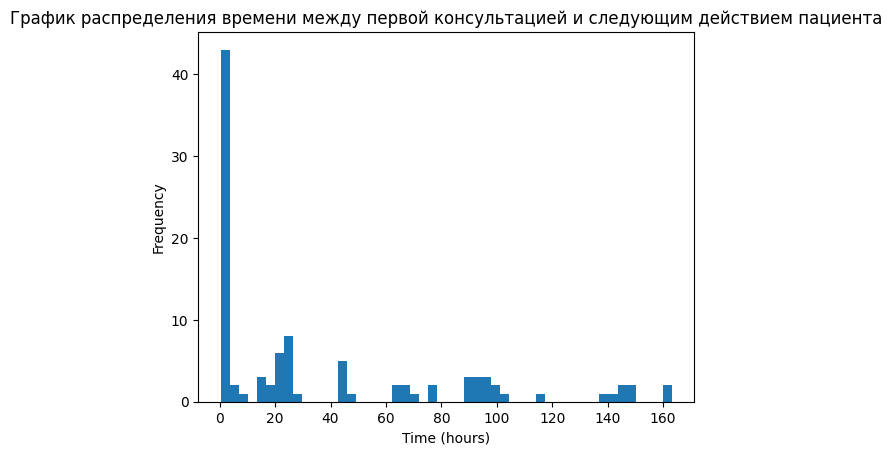

In [55]:
plt.hist([t / 3600 for t in df_11_2.relativetime_s.tolist()], bins=50)
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('График распределения времени между первой консультацией и следующим действием пациента')
plt.show()

#### **12. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA. Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis**

In [56]:
import networkx as nx

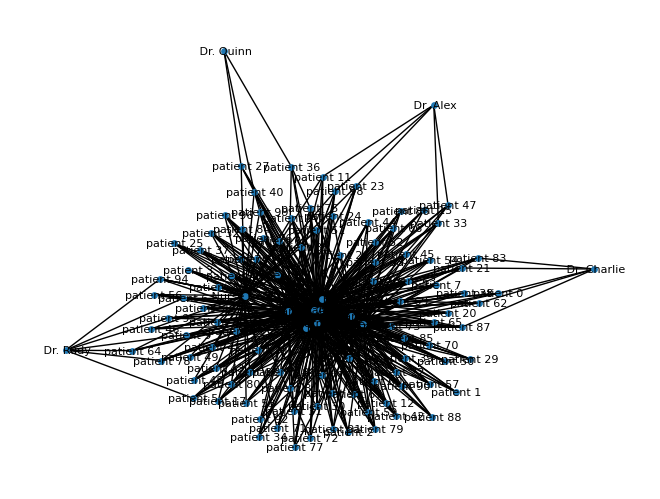

In [57]:
G = nx.Graph()

for case in event_log:
    patient = case.attributes['concept:name']
    if patient not in G.nodes:
        G.add_node(patient)

    for event in case:
        if event['org:resource'] not in G.nodes:
            G.add_node(event['org:resource'])
        G.add_edge(patient, event['org:resource'])

nx.draw(G, with_labels=True, node_size=15, font_size=8)
plt.show()

## Задание. Обнаружение модели процессов

1. По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.
Для каждой модели постройте сети Петри, сравните и сделайте вывод о том, какая модель больше всего подходит в данной задаче (привести значения различных метрик).


In [58]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import graphviz
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

#### **Alpha Miner**

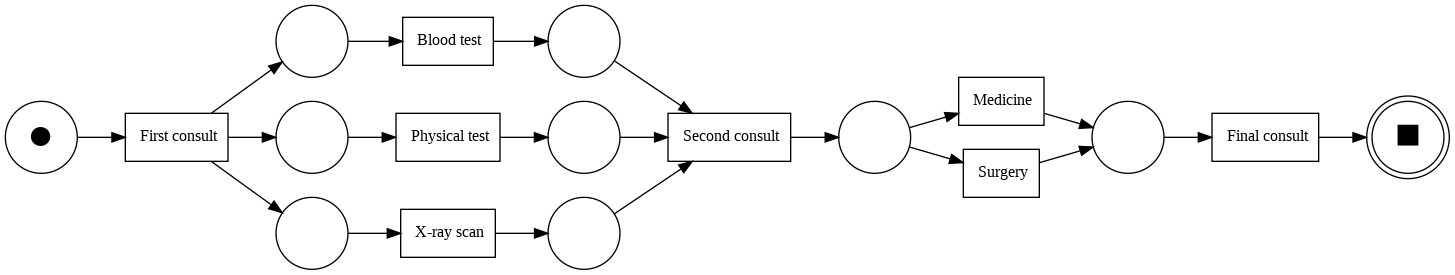

computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Precision = 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Generalization = 0.8823975685045107



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Replay fitness = {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


Simplicity = 0.8181818181818181



In [84]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

net, initial_marking, final_marking = alpha_miner.apply(event_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
precision = precision_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nPrecision = {precision}\n")
generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nGeneralization = {generalization}\n")
replay_fitness = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nReplay fitness = {replay_fitness}\n")
simplicity = simplicity_evaluator.apply(net)
print(f"\nSimplicity = {simplicity}\n")

#### **Heuristics Miner**

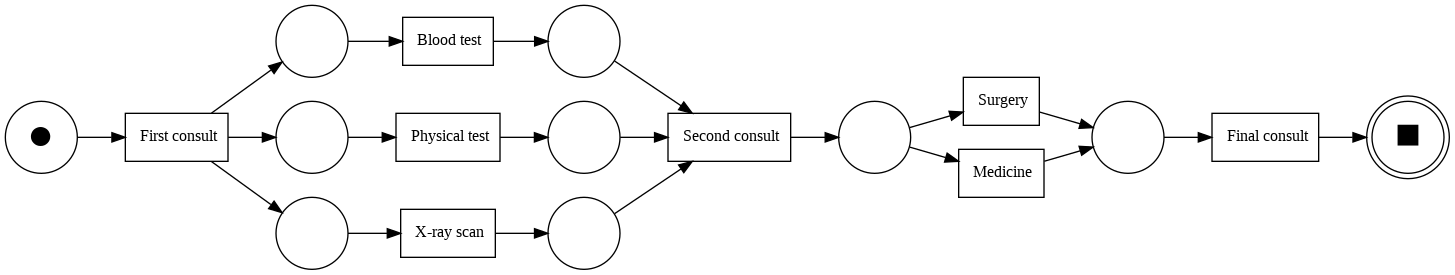

computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Precision = 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Generalization = 0.8823975685045107



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Replay fitness = {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


Simplicity = 0.8181818181818181



In [85]:
from pm4py.algo.discovery.alpha import algorithm as heuristics_miner

net, initial_marking, final_marking = heuristics_miner.apply(event_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
precision = precision_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nPrecision = {precision}\n")
generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nGeneralization = {generalization}\n")
replay_fitness = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nReplay fitness = {replay_fitness}\n")
simplicity = simplicity_evaluator.apply(net)
print(f"\nSimplicity = {simplicity}\n")

#### **Inductive Miner**

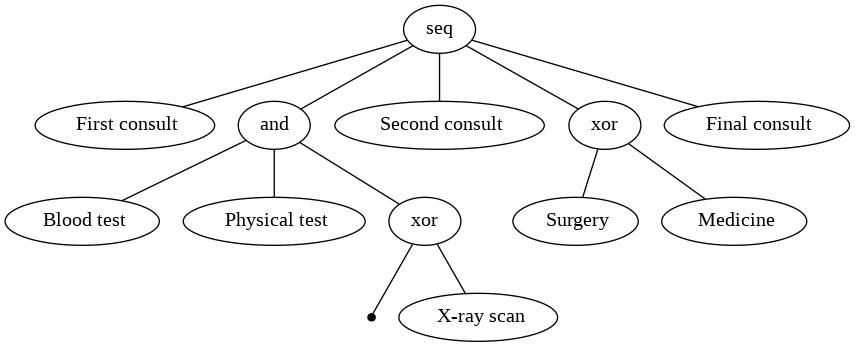

computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Precision = 0.9840848806366048



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Generalization = 0.8603280868910275



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Replay fitness = {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999992248122107}


Simplicity = 0.7599999999999999



In [86]:
import pm4py
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
pt = inductive_miner.apply(event_log)
gviz = pt_visualizer.apply(pt)
pt_visualizer.view(gviz)
precision = precision_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nPrecision = {precision}\n")
generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nGeneralization = {generalization}\n")
replay_fitness = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nReplay fitness = {replay_fitness}\n")
simplicity = simplicity_evaluator.apply(net)
print(f"\nSimplicity = {simplicity}\n")

#### **DFG граф**

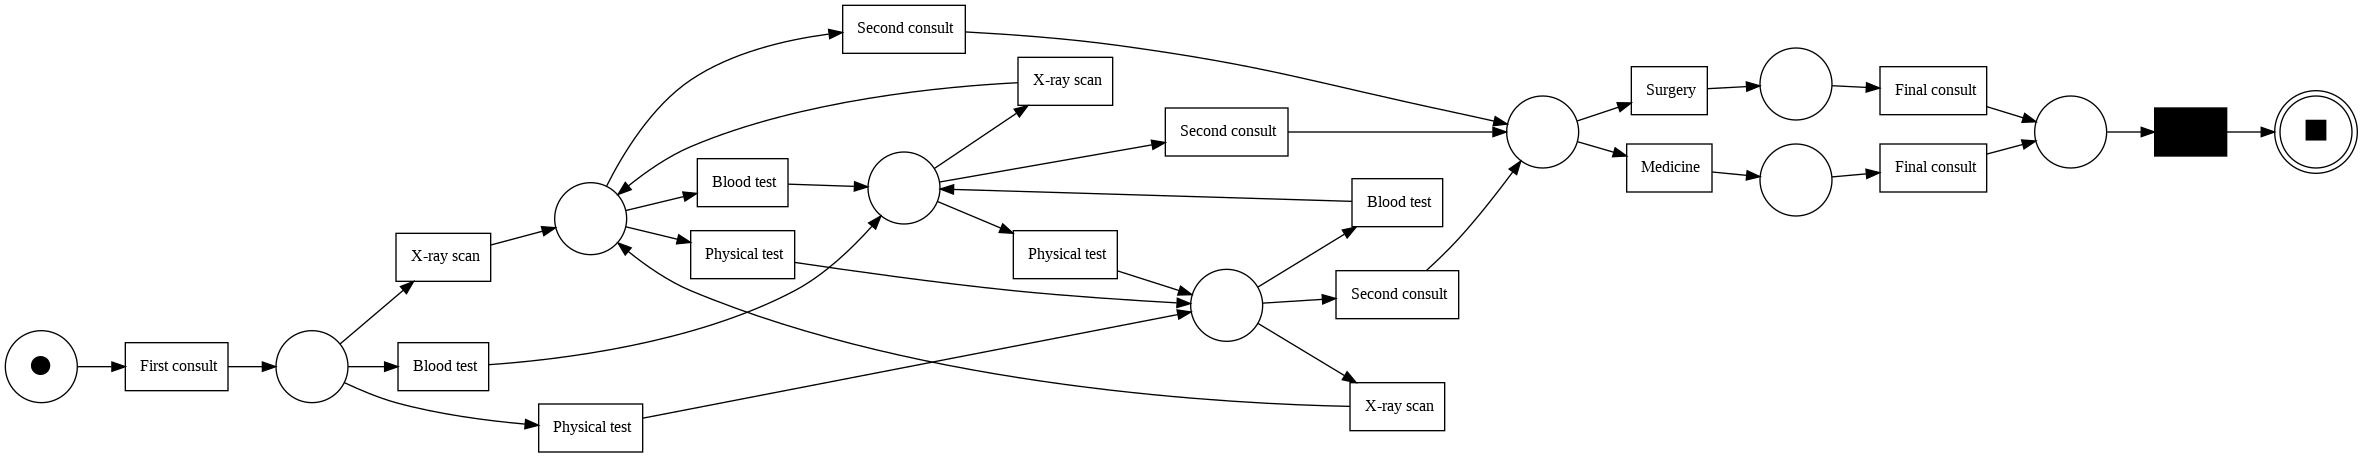

computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Precision = 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Generalization = 0.8341928368975338



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Replay fitness = {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999915967092714}


Simplicity = 0.6363636363636362



In [87]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.objects.conversion.dfg import converter as dfg_mining

dfg = dfg_discovery.apply(event_log)
net, initial_marking, final_marking = dfg_mining.apply(dfg)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
precision = precision_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nPrecision = {precision}\n")
generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nGeneralization = {generalization}\n")
replay_fitness = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"\nReplay fitness = {replay_fitness}\n")
simplicity = simplicity_evaluator.apply(net)
print(f"\nSimplicity = {simplicity}\n")